In [2]:
!nvidia-smi

Thu Dec 12 10:02:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!python --version

Python 3.10.12


In [5]:
!uname -a

Linux 65504f47e275 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


In [6]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   33G  204G  14% /
tmpfs            64M     0   64M   0% /dev
shm              41G     0   41G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs            42G  128K   42G   1% /var/colab
/dev/sda1       242G   35G  208G  15% /kaggle/input
tmpfs            42G     0   42G   0% /proc/acpi
tmpfs            42G     0   42G   0% /proc/scsi
tmpfs            42G     0   42G   0% /sys/firmware


In [1]:
%pip install opencv-python-headless
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [ ]:
!rm -rf detectron2

!git clone https://github.com/facebookresearch/detectron2.git

%cd detectron2
%pip install -e .

Cloning into 'detectron2'...
remote: Enumerating objects: 15819, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 15819 (delta 31), reused 47 (delta 17), pack-reused 15743 (from 1)
Receiving objects: 100% (15819/15819), 6.38 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (11525/11525), done.
/content/detectron2
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.

In [1]:
import os
import cv2
import json
import torch
import random
import detectron2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.structures import Instances
from detectron2.data.transforms import AugInput
from detectron2.utils.visualizer import Visualizer
from concurrent.futures import ProcessPoolExecutor
from detectron2.utils.events import get_event_storage
from detectron2.projects.point_rend import add_pointrend_config
from detectron2.model_zoo import get_config_file, get_checkpoint_url
from detectron2.engine import DefaultPredictor, DefaultTrainer, hooks
from detectron2.modeling.roi_heads import StandardROIHeads,ROI_HEADS_REGISTRY
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader, MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_batch_data_loader, MapDataset

print("Detectron2 installation successful!")

Detectron2 installation successful!


In [2]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
label_mapping_filepath = '/content/drive/MyDrive/Thesis/FoodSeg103/category_id.txt'

label_mapping = {}
with open(label_mapping_filepath, 'r') as f:
    for line in f:
      label, food_name = line.strip().split(maxsplit=1)
      label_mapping[int(label)] = food_name

print(len(label_mapping))
print(label_mapping)

104
{0: 'background', 1: 'candy', 2: 'egg tart', 3: 'french fries', 4: 'chocolate', 5: 'biscuit', 6: 'popcorn', 7: 'pudding', 8: 'ice cream', 9: 'cheese butter', 10: 'cake', 11: 'wine', 12: 'milkshake', 13: 'coffee', 14: 'juice', 15: 'milk', 16: 'tea', 17: 'almond', 18: 'red beans', 19: 'cashew', 20: 'dried cranberries', 21: 'soy', 22: 'walnut', 23: 'peanut', 24: 'egg', 25: 'apple', 26: 'date', 27: 'apricot', 28: 'avocado', 29: 'banana', 30: 'strawberry', 31: 'cherry', 32: 'blueberry', 33: 'raspberry', 34: 'mango', 35: 'olives', 36: 'peach', 37: 'lemon', 38: 'pear', 39: 'fig', 40: 'pineapple', 41: 'grape', 42: 'kiwi', 43: 'melon', 44: 'orange', 45: 'watermelon', 46: 'steak', 47: 'pork', 48: 'chicken duck', 49: 'sausage', 50: 'fried meat', 51: 'lamb', 52: 'sauce', 53: 'crab', 54: 'fish', 55: 'shellfish', 56: 'shrimp', 57: 'soup', 58: 'bread', 59: 'corn', 60: 'hamburg', 61: 'pizza', 62: 'hanamaki baozi', 63: 'wonton dumplings', 64: 'pasta', 65: 'noodles', 66: 'rice', 67: 'pie', 68: 'tofu

In [4]:
train_image_dir = '/content/drive/MyDrive/Thesis/FoodSeg103/Images/img_dir/train'
train_annotation_dir = '/content/drive/MyDrive/Thesis/FoodSeg103/Images/ann_dir/train'

test_image_dir = '/content/drive/MyDrive/Thesis/FoodSeg103/Images/img_dir/test'
test_annotation_dir = '/content/drive/MyDrive/Thesis/FoodSeg103/Images/ann_dir/test'

In [6]:
test_img_files = sorted(os.listdir(test_image_dir))
train_img_files = sorted(os.listdir(train_image_dir))
test_annotation_files = sorted(os.listdir(test_annotation_dir))
train_annotation_files = sorted(os.listdir(train_annotation_dir))
print(len(test_img_files))
print(len(train_img_files))
print(len(test_annotation_files))
print(len(train_annotation_files))

2135
4983
2135
4983


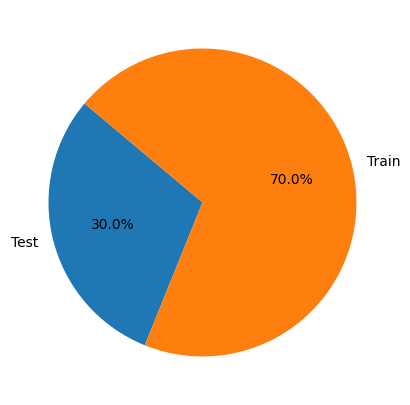

In [10]:
labels = ['Test', 'Train']
sizes = [len(test_img_files), len(train_img_files)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title("Distribution of Test and Train Datasets - FoodSeg103")
plt.show()

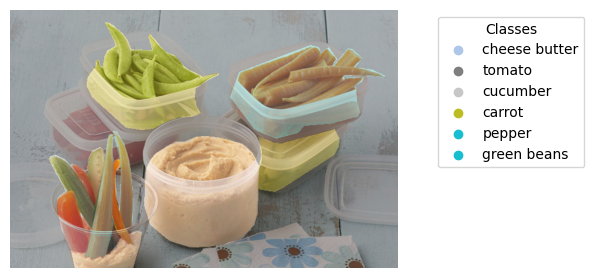

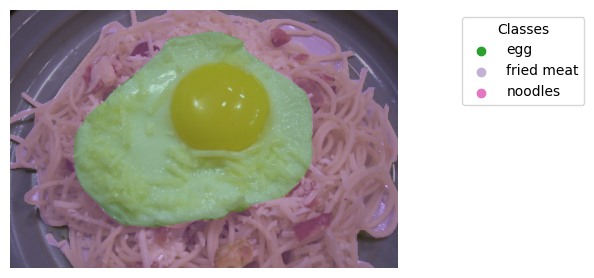

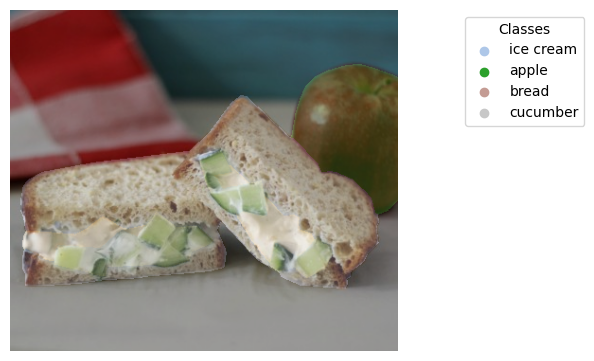

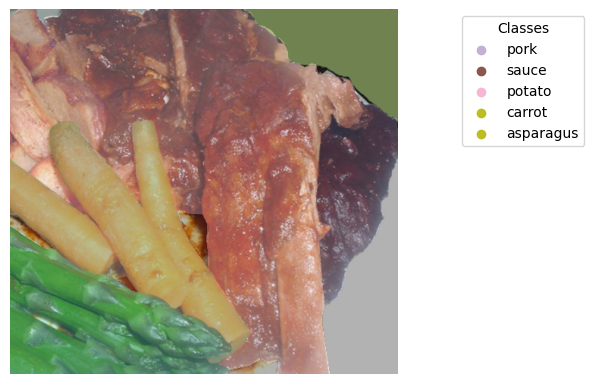

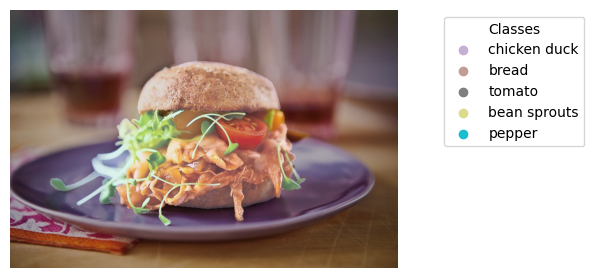

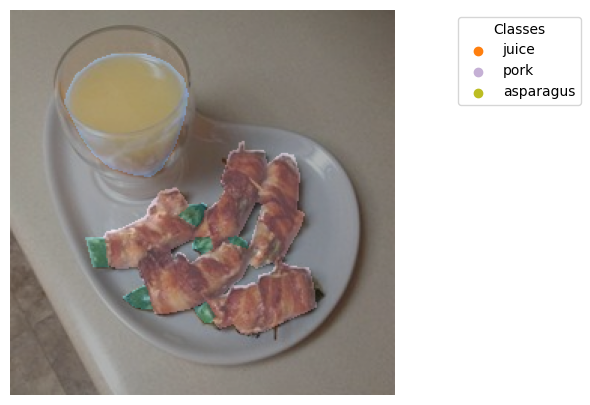

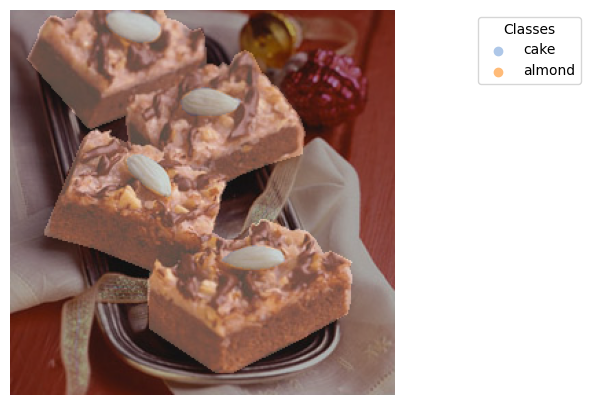

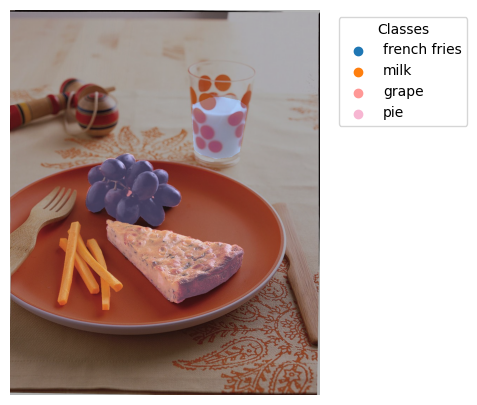

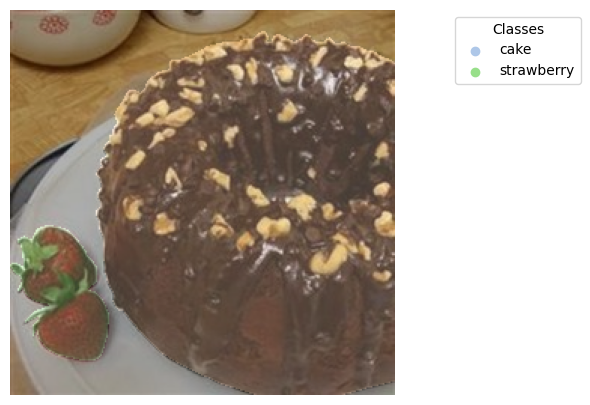

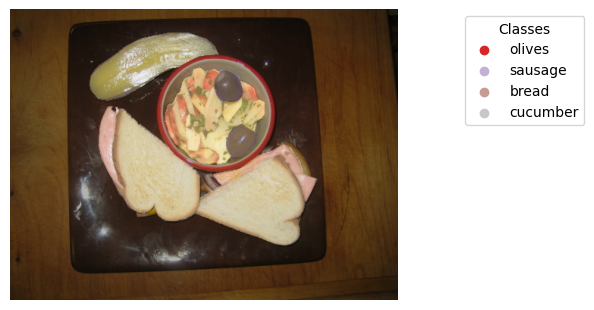

In [9]:
color_palette = plt.cm.tab20(np.linspace(0, 1, len(label_mapping)))[:, :3] * 255

def overlay_annotations(image, annotation, label_mapping):
    overlay = np.zeros_like(image, dtype=np.uint8)

    unique_ids = np.unique(annotation)
    for label_id in unique_ids:
        if label_id == 0:
            continue
        mask = annotation == label_id
        color = color_palette[label_id % len(color_palette)].astype(np.uint8)
        overlay[mask] = color

    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    # plt.title("Image with Annotations")
    plt.axis("off")

    for label_id in unique_ids:
        if label_id == 0:
            continue
        if label_id == 103:
            continue
        plt.scatter([], [], color=color_palette[label_id % len(color_palette)] / 255, label=label_mapping[label_id])
    plt.legend(loc="upper right", title="Classes", bbox_to_anchor=(1.5, 1))
    plt.show()

for annotation_file in random.sample(train_annotation_files, 10):
    annotation_path = os.path.join(train_annotation_dir, annotation_file)
    image_path = os.path.join(train_image_dir, annotation_file.replace('.png', '.jpg'))

    annotation = cv2.imread(annotation_path, cv2.IMREAD_UNCHANGED)
    image = cv2.imread(image_path)

    if image is None or annotation is None:
        print(f"Skipping {annotation_file}: Could not load corresponding image or annotation.")
        continue

    overlay_annotations(image, annotation, label_mapping)

Conversion of Images & Annotations into COCO format

In [ ]:
def process_single_image(filename, image_dir, annotation_dir):
    record = {}
    image_path = os.path.join(image_dir, filename)
    annotation_path = os.path.join(annotation_dir, filename.replace('.jpg', '.png'))

    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not load image {image_path}. Skipping this file.")
        return None

    height, width = image.shape[:2]

    annotation_image = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    if annotation_image is None:
        print(f"Warning: Could not load annotation {annotation_path}. Skipping this file.")
        return None

    record["file_name"] = image_path
    record["image_id"] = filename
    record["height"] = height
    record["width"] = width
    record["sem_seg_file_name"] = annotation_path

    objs = []
    unique_labels = np.unique(annotation_image)

    for label in unique_labels:
        if label == 0:
            continue
        if label == 103:
            continue
        mask = (annotation_image == label).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
          if len(contour) < 3:
            continue
          bbox = cv2.boundingRect(contour)
          obj = {
              "bbox": [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]],
              "bbox_mode": BoxMode.XYXY_ABS,
              "category_id": label,
              "segmentation": [contour.flatten().tolist()],
            }
          objs.append(obj)

    record["annotations"] = objs
    return record

def process_image_with_dirs(filename, image_dir, annotation_dir):
    return process_single_image(filename, image_dir, annotation_dir)

def get_foodseg103_dicts_parallel(image_dir, annotation_dir):
    image_files = sorted(os.listdir(image_dir))

    with ProcessPoolExecutor() as executor:
        dataset_dicts = list(executor.map(process_image_with_dirs, image_files, [image_dir] * len(image_files), [annotation_dir] * len(image_files)))

    return [record for record in dataset_dicts if record is not None]

train_dataset_dicts = get_foodseg103_dicts_parallel(train_image_dir, train_annotation_dir)
test_dataset_dicts = get_foodseg103_dicts_parallel(test_image_dir, test_annotation_dir)

In [ ]:
def count_instances_detectron2(dataset_dicts, label_mapping):
    counts = {}

    for record in dataset_dicts:
        for annotation in record['annotations']:
            category_id = annotation['category_id']
            counts[category_id] = counts.get(category_id, 0) + 1

    sorted_counts = dict(sorted(counts.items()))

    print("Instance counts for Detectron2 (sorted by category ID):")
    for category_id, count in sorted_counts.items():
        class_name = label_mapping.get(category_id, "Unknown")
        print(f"Category {category_id} ({class_name}): {count}")

    return sorted_counts

In [ ]:
class_counts = count_instances_detectron2(train_dataset_dicts, label_mapping)

Instance counts for Detectron2 (sorted by category ID):
Category 1 (candy): 56
Category 2 (egg tart): 8
Category 3 (french fries): 189
Category 4 (chocolate): 151
Category 5 (biscuit): 345
Category 6 (popcorn): 34
Category 7 (pudding): 5
Category 8 (ice cream): 855
Category 9 (cheese butter): 437
Category 10 (cake): 475
Category 11 (wine): 117
Category 12 (milkshake): 99
Category 13 (coffee): 136
Category 14 (juice): 151
Category 15 (milk): 47
Category 16 (tea): 29
Category 17 (almond): 266
Category 18 (red beans): 44
Category 19 (cashew): 43
Category 20 (dried cranberries): 79
Category 21 (soy): 38
Category 22 (walnut): 99
Category 23 (peanut): 16
Category 24 (egg): 305
Category 25 (apple): 190
Category 26 (date): 14
Category 27 (apricot): 39
Category 28 (avocado): 96
Category 29 (banana): 156
Category 30 (strawberry): 718
Category 31 (cherry): 463
Category 32 (blueberry): 554
Category 33 (raspberry): 107
Category 34 (mango): 75
Category 35 (olives): 93
Category 36 (peach): 132
Catego

In [ ]:
def calculate_class_weights(class_counts):
    total_instances = sum(class_counts.values())

    weights = {category_id: 1.0 / (count + 1e-6) for category_id, count in class_counts.items()}

    total_weight = sum(weights.values())
    # print(total_weight)
    normalized_weights = {category_id: weight / total_weight for category_id, weight in weights.items()}

    return normalized_weights

In [ ]:
class_weights = []

class_weights_dict = calculate_class_weights(class_counts)
print(f"Length of label mapping: {len(label_mapping)}")

for i in range(0, len(label_mapping) + 1):
    class_weights.append(class_weights_dict.get(i, 0))
class_weights.pop()

print(f"Class weights: {class_weights}")
print(f"Length of class weights: {len(class_weights)}")

Length of label mapping: 104
Class weights: [0, 0.007400571557604896, 0.051803995352806304, 0.0021927619705485913, 0.002744582860144787, 0.0012012522128266479, 0.012189176542272624, 0.08288638634801188, 0.00048471580601371924, 0.0009483570107050085, 0.0008724884500083311, 0.0035421539408913827, 0.004186181923639028, 0.003047294202787879, 0.002744582860144787, 0.008817702251249861, 0.014290758632265073, 0.0015580150867234234, 0.009418909209262194, 0.009637953604383537, 0.0052459748022844425, 0.01090610536106159, 0.004186181923639028, 0.025901999295277898, 0.00135879348612345, 0.002181221118132761, 0.029602284644582935, 0.010626461641025235, 0.004317000107390058, 0.002656615461345066, 0.0005772033621855744, 0.0008951015415363806, 0.0007480722272172807, 0.0038731963621799004, 0.005525760121342475, 0.004456258173872985, 0.003139636450657646, 0.0006816316018829179, 0.008126117774516235, 0.008126117774516235, 0.0021252923718007863, 0.002240173039925798, 0.006475500127358525, 0.01036080010664

In [ ]:
print("Normalized Class Weights:")
for category_id, weight in class_weights_dict.items():
    class_name = label_mapping.get(category_id, "Unknown")
    print(f"Category {category_id} ({class_name}): {weight:.6f}")

Normalized Class Weights:
Category 1 (candy): 0.007401
Category 2 (egg tart): 0.051804
Category 3 (french fries): 0.002193
Category 4 (chocolate): 0.002745
Category 5 (biscuit): 0.001201
Category 6 (popcorn): 0.012189
Category 7 (pudding): 0.082886
Category 8 (ice cream): 0.000485
Category 9 (cheese butter): 0.000948
Category 10 (cake): 0.000872
Category 11 (wine): 0.003542
Category 12 (milkshake): 0.004186
Category 13 (coffee): 0.003047
Category 14 (juice): 0.002745
Category 15 (milk): 0.008818
Category 16 (tea): 0.014291
Category 17 (almond): 0.001558
Category 18 (red beans): 0.009419
Category 19 (cashew): 0.009638
Category 20 (dried cranberries): 0.005246
Category 21 (soy): 0.010906
Category 22 (walnut): 0.004186
Category 23 (peanut): 0.025902
Category 24 (egg): 0.001359
Category 25 (apple): 0.002181
Category 26 (date): 0.029602
Category 27 (apricot): 0.010626
Category 28 (avocado): 0.004317
Category 29 (banana): 0.002657
Category 30 (strawberry): 0.000577
Category 31 (cherry): 0.00

Dataset Registration

In [ ]:
if "foodseg103_train" in DatasetCatalog.list():
    DatasetCatalog.remove("foodseg103_train")
if "foodseg103_test" in DatasetCatalog.list():
    DatasetCatalog.remove("foodseg103_test")

if "foodseg103_train" in MetadataCatalog.list():
    MetadataCatalog.remove("foodseg103_train")
if "foodseg103_test" in MetadataCatalog.list():
    MetadataCatalog.remove("foodseg103_test")

DatasetCatalog.register("foodseg103_test", lambda: get_foodseg103_dicts_parallel(test_image_dir, test_annotation_dir))
DatasetCatalog.register("foodseg103_train", lambda: get_foodseg103_dicts_parallel(train_image_dir, train_annotation_dir))

MetadataCatalog.get("foodseg103_test").set(thing_classes=list(label_mapping.values()))
MetadataCatalog.get("foodseg103_train").set(thing_classes=list(label_mapping.values()))

foodseg_metadata_test = MetadataCatalog.get("foodseg103_test")
foodseg_metadata_train = MetadataCatalog.get("foodseg103_train")

In [ ]:
print(f"Number of thing_classes: { len(MetadataCatalog.get('foodseg103_test').thing_classes) }")
print(f"Number of thing_classes: { len(MetadataCatalog.get('foodseg103_train').thing_classes) }")

Number of thing_classes: 104
Number of thing_classes: 104


Model Training

In [ ]:
from detectron2.data.transforms import Transform, Augmentation

class GaussianNoiseTransform(Transform):
    def __init__(self, mean=0, std=0.01):
        super().__init__()
        self.mean = mean
        self.std = std

    def apply_image(self, img):
        noise = np.random.normal(self.mean, self.std, img.shape).astype(np.float32)
        img = img + noise
        return np.clip(img, 0, 255)

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        return segmentation


class GaussianNoise(Augmentation):
    def __init__(self, mean=0, std=0.01):
        super().__init__()
        self.mean = mean
        self.std = std

    def get_transform(self, image):
        return GaussianNoiseTransform(self.mean, self.std)

In [ ]:
import torchvision.transforms as T

class TorchColorJitterTransform(Transform):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05):
        super().__init__()
        self.transform = T.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def apply_image(self, img):
        img = np.array(img, dtype=np.float32)
        img = T.functional.to_pil_image(img.astype(np.uint8))
        img = self.transform(img)
        return np.asarray(img, dtype=np.float32)

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        return segmentation


class TorchColorJitter(Augmentation):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05):
        super().__init__()
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def get_transform(self, image):
        return TorchColorJitterTransform(
            brightness=self.brightness,
            contrast=self.contrast,
            saturation=self.saturation,
            hue=self.hue,
        )

In [ ]:
import torch.nn.functional as F

if "WeightedROIHeads" in ROI_HEADS_REGISTRY:
    del ROI_HEADS_REGISTRY._obj_map["WeightedROIHeads"]

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, reduction="none")
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()


class DiceLoss(torch.nn.Module):
    def forward(self, predictions, targets):
        smooth = 1.0
        predictions = torch.sigmoid(predictions)
        intersection = (predictions * targets).sum(dim=(1, 2, 3))
        union = predictions.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
        dice_loss = 1 - (2.0 * intersection + smooth) / (union + smooth)
        return dice_loss.mean()


@ROI_HEADS_REGISTRY.register()
class WeightedROIHeads(StandardROIHeads):
    def __init__(self, cfg, input_shape):
        super().__init__(cfg, input_shape)
        self.class_weights = torch.tensor(cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS).cuda()
        self.focal_loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
        self.dice_loss_fn = DiceLoss()

    def _log_prediction_stats(self, predictions, targets):
        storage = get_event_storage()
        pred_classes = predictions.argmax(dim=1)
        num_instances = len(targets)
        storage.put_scalar("cls_accuracy", (pred_classes == targets).sum().item() / max(num_instances, 1e-5))

    def _classification_loss(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, weight=self.class_weights)

        focal_loss = self.focal_loss_fn(predictions, targets)

        combined_loss = 0.5 * ce_loss + 0.5 * focal_loss
        return combined_loss

    def _segmentation_loss(self, mask_logits, mask_targets):
        return self.dice_loss_fn(mask_logits, mask_targets)

    def _loss(self, predictions, targets, mask_logits=None, mask_targets=None):
        classification_loss = self._classification_loss(predictions, targets)
        self._log_prediction_stats(predictions, targets)

        if mask_logits is not None and mask_targets is not None:
            segmentation_loss = self._segmentation_loss(mask_logits, mask_targets)
        else:
            segmentation_loss = 0.0

        total_loss = classification_loss + segmentation_loss
        return total_loss

In [ ]:
from detectron2.data.transforms import (RandomFlip, RandomBrightness, RandomContrast, RandomRotation, ResizeShortestEdge, RandomCrop)

class CustomTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.validation_losses = {}
        self.early_stopped = False

    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [
            RandomFlip(horizontal=True, vertical=False),
            RandomBrightness(0.8, 1.2),
            RandomContrast(0.6, 1.4),
            RandomRotation([-15, 15]),
            ResizeShortestEdge(
                short_edge_length=[640, 720, 800, 880, 960], max_size=1333, sample_style="choice"
            ),
            RandomCrop("relative_range", [0.8, 0.8]),
            GaussianNoise(mean=0, std=0.01),
            TorchColorJitter(
                brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05
            ),
        ]

        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks_list = super().build_hooks()
        hooks_list.insert(
            -1,  # Before the checkpointing hook
            hooks.EvalHook(
                self.cfg.TEST.EVAL_PERIOD,
                self._log_validation_loss
            ),
        )
        return hooks_list

    def _log_validation_loss(self):
        data_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
        loss_sum = 0
        count = 0

        was_training = self.model.training
        self.model.eval()

        with torch.no_grad():
            for inputs in data_loader:
                outputs = self.model(inputs)
                if "instances" in inputs[0]:
                    loss_dict = self.model.roi_heads.loss(outputs, inputs)
                    losses = sum(loss_dict.values())
                    loss_sum += losses.item()
                    count += 1

        if was_training:
            self.model.train()

        avg_validation_loss = loss_sum / count if count > 0 else 0.0
        self.validation_losses[self.iter] = avg_validation_loss
        self.storage.put_scalar("validation_loss", avg_validation_loss)
        print(f"Validation Loss at iteration {self.iter}: {avg_validation_loss}")

    def save_model(self):
        model_path = os.path.join(self.cfg.OUTPUT_DIR, "model_final.pth")
        torch.save(self.model.state_dict(), model_path)
        print(f"Model saved to {model_path}")


class EarlyStoppingHook(hooks.HookBase):
    def __init__(self, trainer, patience=5, threshold=0.01):
        self.patience = patience
        self.threshold = threshold
        self.best_loss = float("inf")
        self.counter = 0
        self.trainer = trainer

    def after_step(self):
        if self.trainer.iter in self.trainer.validation_losses:
            current_loss = self.trainer.validation_losses[self.trainer.iter]

            if current_loss < self.best_loss - self.threshold:
                self.best_loss = current_loss
                self.counter = 0
            else:
                self.counter += 1

            if self.counter >= self.patience:
                print(f"Early stopping triggered at iteration {self.trainer.iter}.")
                self.trainer.early_stopped = True
                self.trainer.save_model()
                raise StopIteration

In [ ]:
cfg = get_cfg()

add_pointrend_config(cfg)

cfg.merge_from_file("/content/detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")

cfg.DATASETS.TRAIN = ("foodseg103_train",)
cfg.DATASETS.TEST = ("foodseg103_test",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"
cfg.MODEL.ROI_HEADS.NAME = "WeightedROIHeads"
cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS = class_weights

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 50000
cfg.SOLVER.STEPS = (15000, 18000)
cfg.SOLVER.GAMMA = 0.1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(label_mapping) - 1
cfg.MODEL.POINT_HEAD.NUM_CLASSES = len(label_mapping) - 1

cfg.TEST.EVAL_PERIOD = 1000

cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 3000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1500
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000

cfg.MODEL.BACKBONE.FREEZE_AT = 0

cfg.TEST.EVAL_PERIOD = 1000

cfg.OUTPUT_DIR = "./output_foodseg103"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CustomTrainer(cfg)
early_stopping_hook = EarlyStoppingHook(trainer=trainer, patience=25, threshold=0.01)
trainer.register_hooks([early_stopping_hook])
trainer.resume_or_load(resume=False)

try:
    trainer.train()
except StopIteration:
    print("Training stopped early due to early stopping criteria.")

[12/04 16:19:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.coarse_head.prediction.{bias, weight}
roi_heads.mask_head.point_head.fc1.weight
roi_heads.mask_head.point_head.fc2.weight
roi_heads.mask_head.point_head.fc3.weight
roi_heads.mask_head.point_head.predictor.{bias, weight}


Streaming output truncated to the last 5000 lines.
[12/04 18:07:44 d2.utils.events]:  eta: 9:28:55  iter: 5279  total_loss: 1.299  loss_cls: 0.412  loss_box_reg: 0.2965  loss_mask: 0.2076  loss_mask_point: 0.3249  loss_rpn_cls: 0.01618  loss_rpn_loc: 0.03433  validation_loss: 0    time: 0.7966  last_time: 1.0100  data_time: 0.2416  last_data_time: 0.4748   lr: 0.001  max_mem: 27884M
[12/04 18:07:58 d2.utils.events]:  eta: 9:25:18  iter: 5299  total_loss: 1.2  loss_cls: 0.3638  loss_box_reg: 0.2585  loss_mask: 0.2003  loss_mask_point: 0.3125  loss_rpn_cls: 0.01566  loss_rpn_loc: 0.03213  validation_loss: 0    time: 0.7963  last_time: 0.9163  data_time: 0.2059  last_data_time: 0.3932   lr: 0.001  max_mem: 27884M
[12/04 18:08:13 d2.utils.events]:  eta: 9:25:40  iter: 5319  total_loss: 1.302  loss_cls: 0.4388  loss_box_reg: 0.2884  loss_mask: 0.2118  loss_mask_point: 0.307  loss_rpn_cls: 0.01747  loss_rpn_loc: 0.03262  validation_loss: 0    time: 0.7961  last_time: 0.7416  data_time: 0.233

In [ ]:
import shutil

source_folder = "/content/sample_data/output_foodseg103"

destination_folder = "/content/drive/MyDrive/"

shutil.move(source_folder, destination_folder)
print(f"Folder moved from {source_folder} to {destination_folder}")

Folder moved from /content/sample_data/output_foodseg103 to /content/drive/MyDrive/


In [ ]:
import os
import shutil

save_path = "/content/drive/MyDrive/Thesis/model_foodseg_POINTREND"
os.makedirs(save_path, exist_ok=True)

fine_tuned_weights_path = "/content/drive/MyDrive/output_foodseg103/model_final.pth"

if not os.path.exists(fine_tuned_weights_path):
    raise FileNotFoundError(f"Fine-tuned weights not found at {fine_tuned_weights_path}. Check your training output directory.")

model_weights_path = os.path.join(save_path, "model_final.pth")
shutil.copy(fine_tuned_weights_path, model_weights_path)
print(f"Fine-tuned model weights saved to: {model_weights_path}")

config_path = os.path.join(save_path, "model_config.yaml")
with open(config_path, "w") as f:
    f.write(cfg.dump())
print(f"Model configuration saved to: {config_path}")

Fine-tuned model weights saved to: /content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_final.pth
Model configuration saved to: /content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml


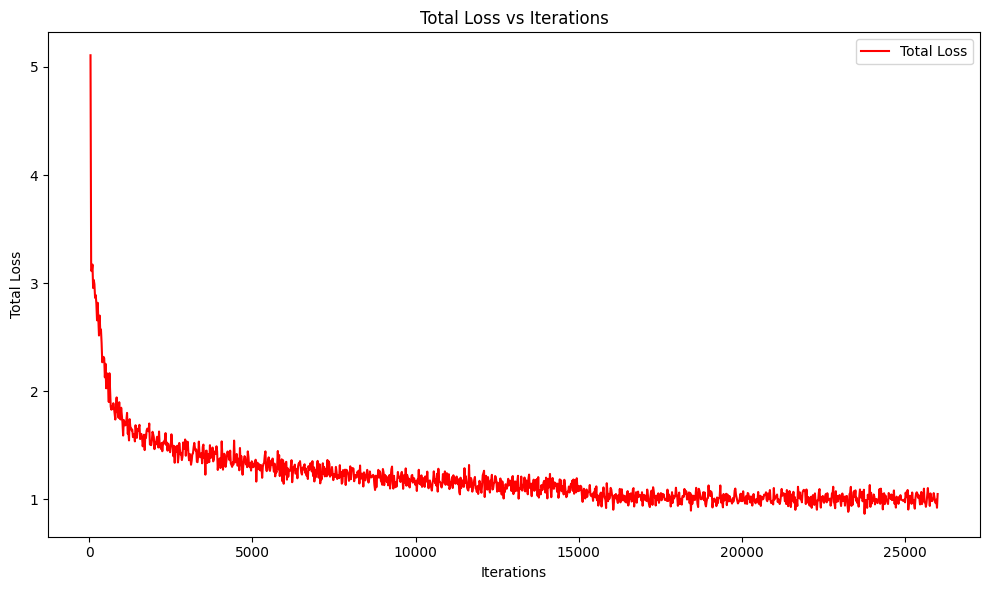

In [8]:
json_file_path = "/content/drive/MyDrive/output_foodseg103/metrics.json"

data = []
with open(json_file_path, "r") as f:
    for line in f:
        data.append(json.loads(line.strip()))

iterations = []
total_loss_values = []

for entry in data:
    if "iteration" in entry and "total_loss" in entry:
        iterations.append(entry["iteration"])
        total_loss_values.append(entry["total_loss"])
    else:
        continue

plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss_values, label='Total Loss', color='red')
plt.title("Total Loss vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Total Loss")
plt.grid(False)
plt.legend()
plt.tight_layout()

plt.show()

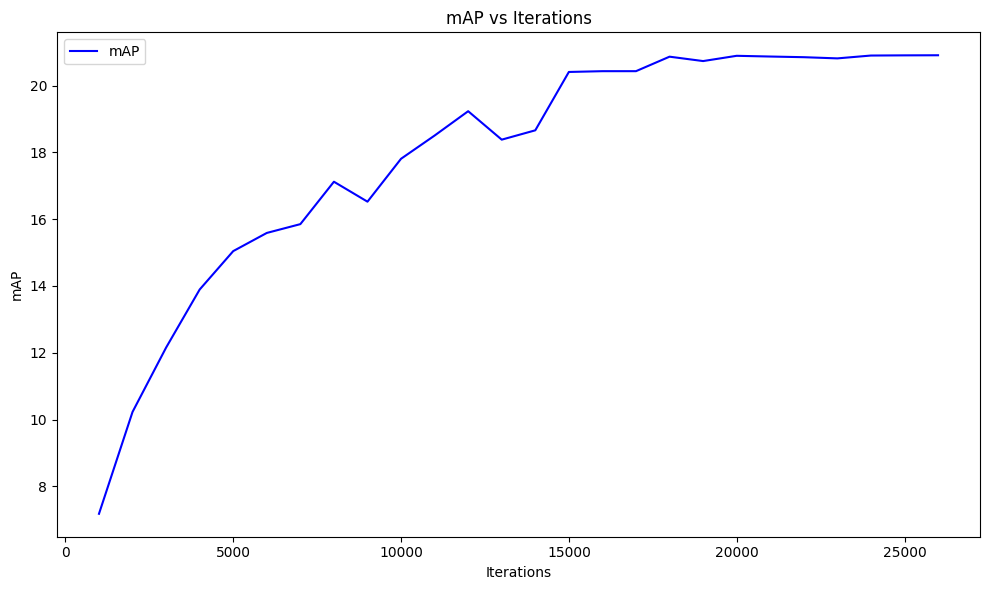

In [7]:
json_file_path = "/content/drive/MyDrive/output_foodseg103/metrics.json"

data = []
with open(json_file_path, "r") as f:
    for line in f:
        data.append(json.loads(line.strip()))

iterations = []
segm_ap_values = []

for entry in data:
    if "iteration" in entry and "segm/AP" in entry:
        iterations.append(entry["iteration"])
        segm_ap_values.append(entry["segm/AP"])

plt.figure(figsize=(10, 6))
plt.plot(iterations, segm_ap_values, label='mAP', color='blue')
plt.title("mAP vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("mAP")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import yaml

with open("/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml", 'r') as file:
    config = yaml.safe_load(file)

if 'ROI_HEADS' in config['MODEL']:
    if 'CLASS_WEIGHTS' in config['MODEL']['ROI_HEADS']:
        print("Removing CLASS_WEIGHTS from ROI_HEADS...")
        del config['MODEL']['ROI_HEADS']['CLASS_WEIGHTS']
    else:
        print("CLASS_WEIGHTS not found under ROI_HEADS.")
else:
    print("ROI_HEADS not found in the configuration.")

with open('/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml', 'w') as file:
    yaml.safe_dump(config, file, default_flow_style=False)

In [ ]:
cfg = get_cfg()
add_pointrend_config(cfg)

cfg.MODEL.MASK_ON = True
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(label_mapping) - 1
cfg.merge_from_file("/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_final.pth"

cfg.MODEL.ROI_HEADS.NAME = "WeightedROIHeads"
cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS = class_weights
cfg.MODEL.POINT_HEAD.NUM_CLASSES = len(label_mapping) - 1

test_dataset_name = "foodseg103_test"
test_metadata = MetadataCatalog.get(test_dataset_name)

predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator(test_dataset_name, cfg, False, output_dir="./evaluation_output/")

val_loader = build_detection_test_loader(cfg, test_dataset_name)

print("Running evaluation...")
results = inference_on_dataset(predictor.model, val_loader, evaluator)

print("Evaluation Results:", results)

Running evaluation...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.

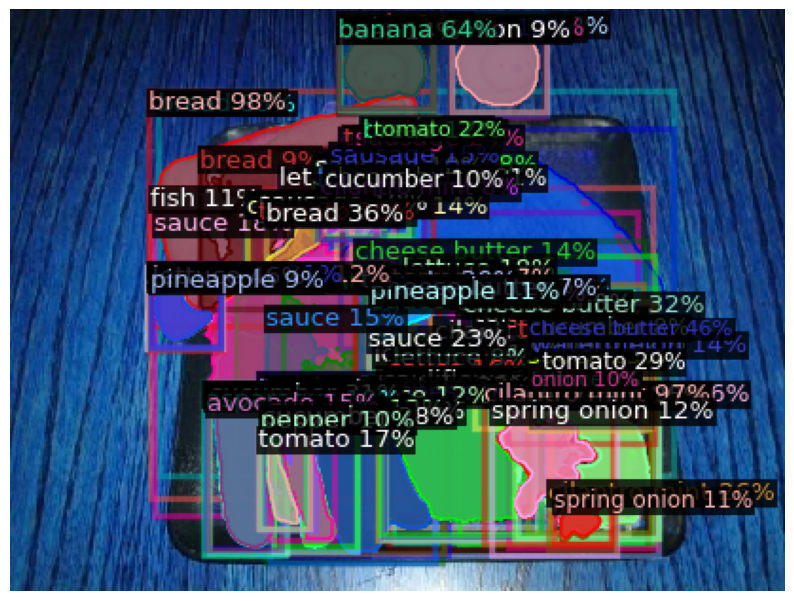

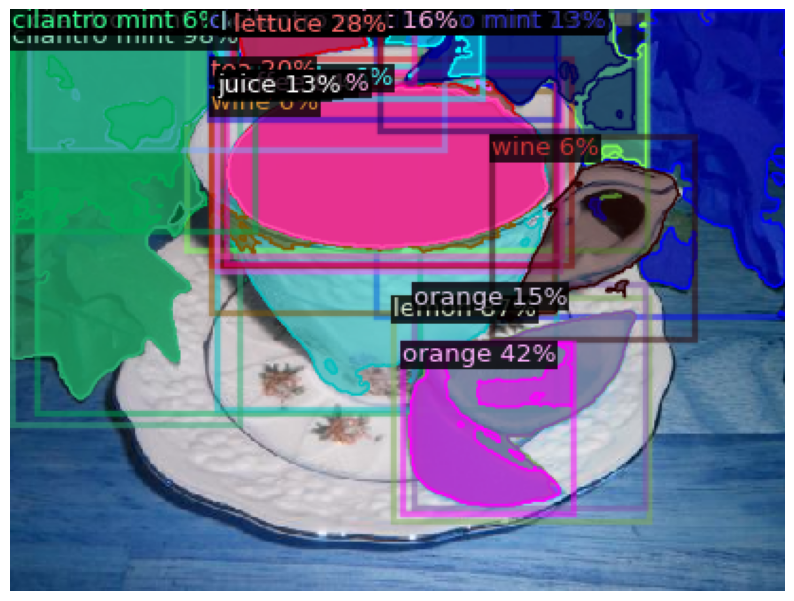

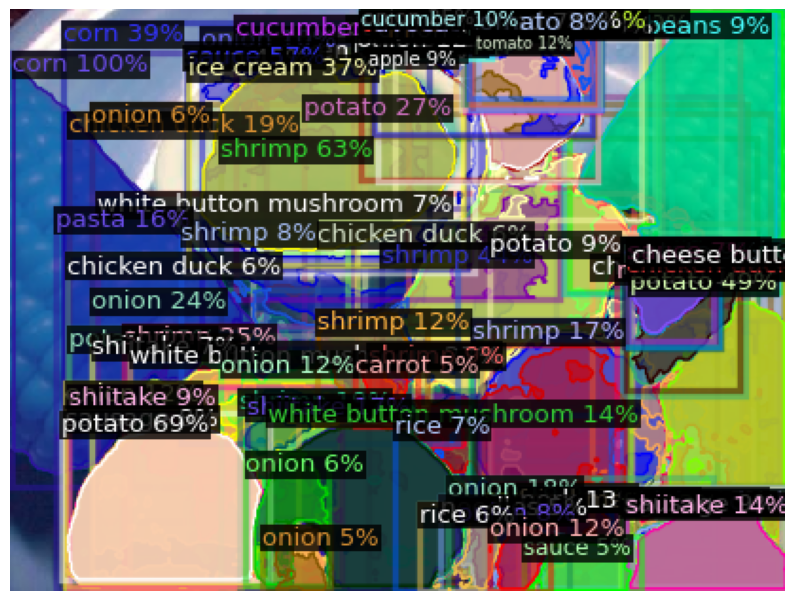

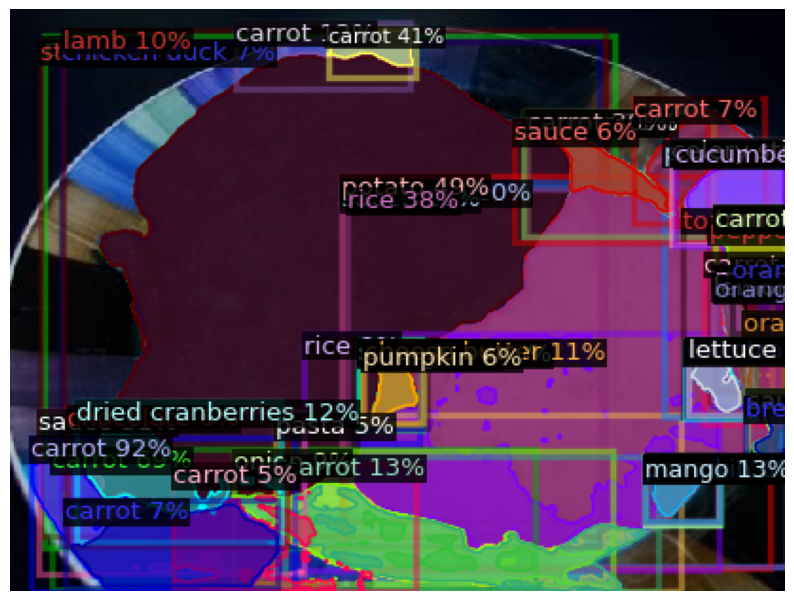

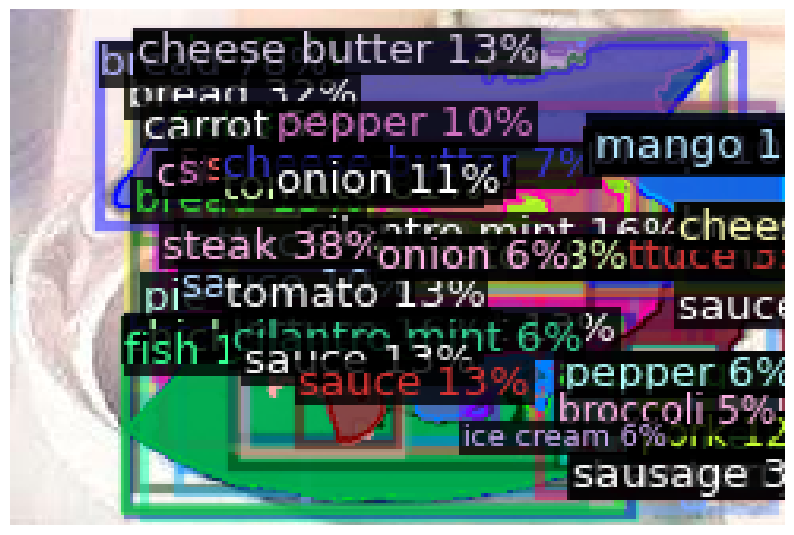

In [ ]:
for d in random.sample(test_dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    if img is None:
        print(f"Could not load image {d['file_name']}")
        continue

    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=foodseg_metadata_test, scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

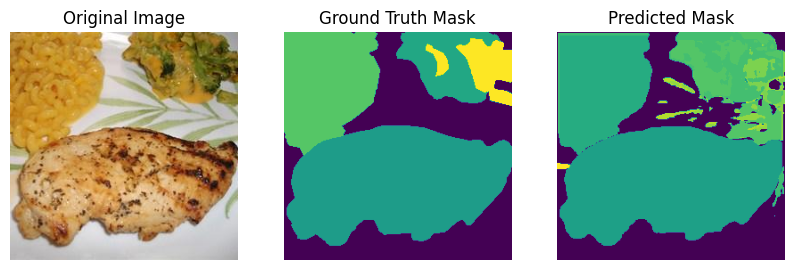

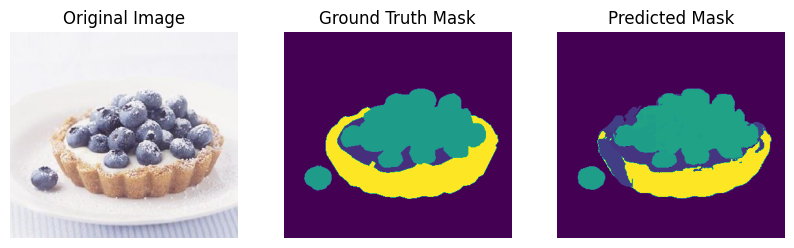

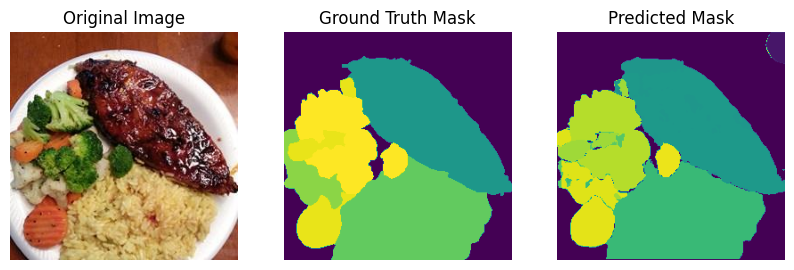

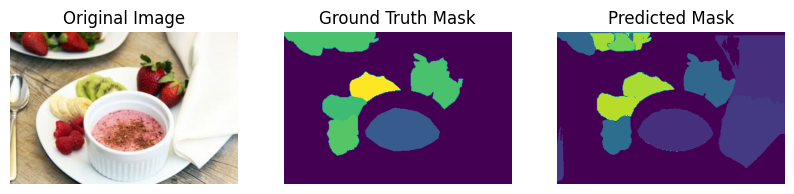

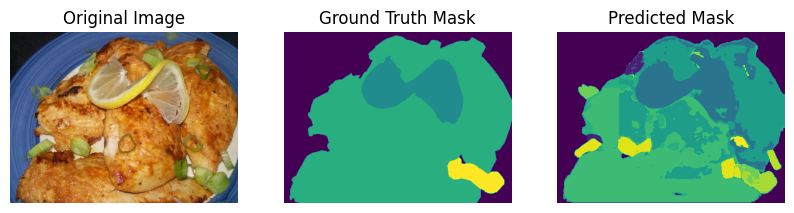

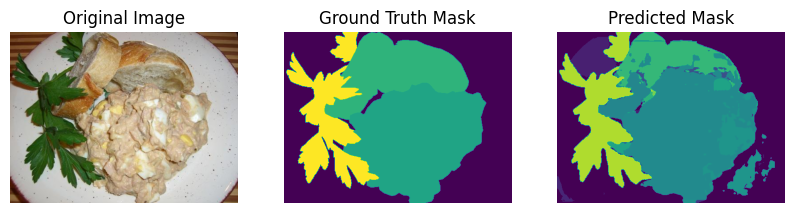

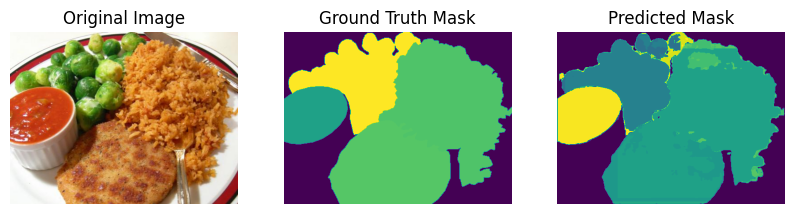

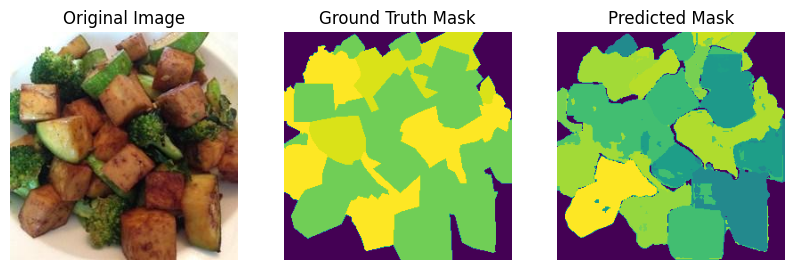

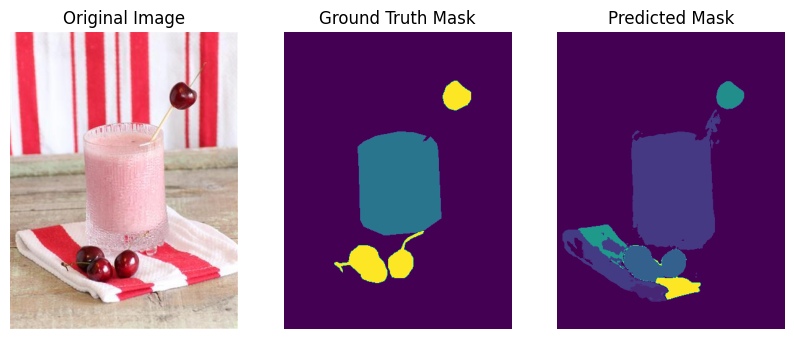

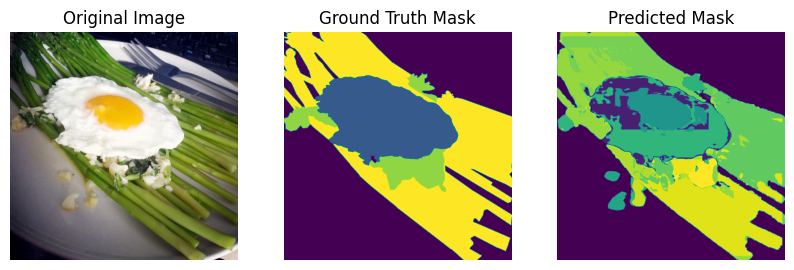

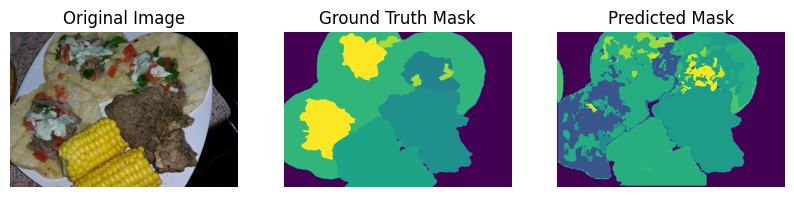

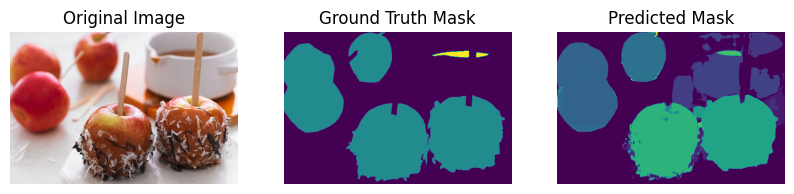

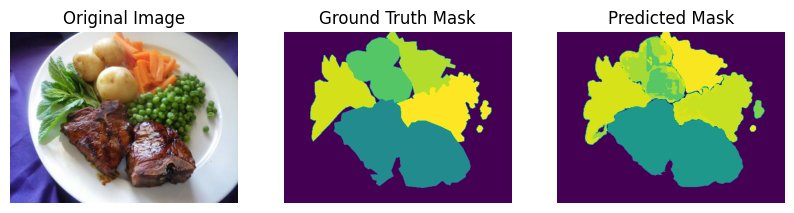

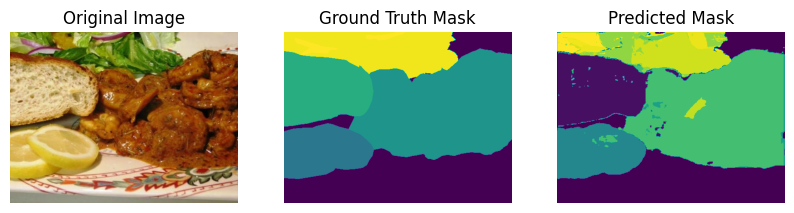

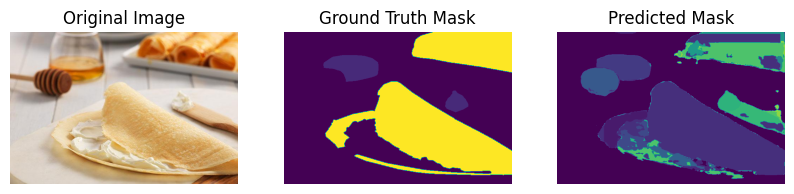

In [ ]:
for d in random.sample(test_dataset_dicts, 15):
    img = cv2.imread(d["file_name"])
    if img is None:
        continue

    gt_mask_path = d["sem_seg_file_name"]
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)

    outputs = predictor(img)
    pred_masks = outputs["instances"].pred_masks.cpu().numpy()
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    pred_mask = np.zeros_like(gt_mask, dtype=np.uint8)
    for idx, cls in enumerate(pred_classes):
        pred_mask[pred_masks[idx]] = cls + 1

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask, cmap="viridis")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="viridis")
    plt.axis("off")

    plt.show()